In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os

In [19]:
df_category = pd.read_csv("amazon_categories.csv")
df_sku = pd.read_csv("amazon_products.csv")
df_sku = (
    df_sku
        .merge(df_category[['id', 'category_name']],   
               left_on='category_id',               
               right_on='id',                      
               how='left',                
               validate='m:1')                     
        .drop(columns='id')                           
)

# calculate discount rate
df_sku["discount_pct"] = (
1 - df_sku["price"] / df_sku["listPrice"].replace(0, np.nan)
).clip(0, 1).fillna(0)

# data cleaning
df_product = df_sku[df_sku['price'] != 0]

# Data Sampling 

## Sensitive product group 

In [3]:
# select category 'Sexual Wellness Products'
df_sw = (df_product[df_product['category_name'] == 'Sexual Wellness Products']
        .copy()
        .reset_index(drop=True)) 

In [4]:
# classify product into 4 sub-category
PATTERNS = {
    "Condoms": r"\b("
        r"condoms?|ultra[- ]?thin|dotted|ribbed|latex condom|"
        r"extra (?:safe|lubricated)|non[- ]?latex|tight fit|"
        r"trojan|durex|okamoto"
    r")\b",

    "Lubricants": r"\b("
        r"lube|lubricant|personal lube|water[- ]?based|silicone[- ]?based|"
        r"hybrid lube|warming lube|cooling lube|flavored lube|gel|glide|"
        r"astroglide|k[- ]?y|[0-9]+ ?(?:oz|ml)"
    r")\b",

    "Lingerie & Footwear": r"\b("
        r"lingerie|bra|bralette|pant(?:y|ies)|thong|g[- ]?string|garter|"
        r"bodysuit|teddy|catsuit|costume|cosplay|stockings?|"
        r"thigh[- ]?highs?|fishnet|latex dress|heels?|stilettos?|boots?"
    r")\b",

    "Adult Toys": r"\b("
        r"vibrator|vibrators|wand|bullet|rabbit|suction|"
        r"dildo|dildos|realistic dildo|masturbator|stroker|fleshlight|"
        r"sleeve|prostate|plug|anal plug|ring|c[- ]?ring|bondage kit|"
        r"sex toy|combo set|"
        r"bondage|bdsm|restraints?|handcuffs?|blindfolds?|gag|"
        r"nipple (?:clamps?|suckers?)|"
        r"penis (?:pump|extender|sleeve)|cock cage|harness(?:es)?|"
        r"spreaders?|whip|flogger|paddle|"
        r"sex dice|couples? game(?:s)?"
    r")\b",
}

COMPILED = {cls: re.compile(pat, re.I) for cls, pat in PATTERNS.items()}

def classify_title(title: str) -> str:
    title = title or ""
    for cls in ["Condoms", "Lubricants", "Lingerie & Footwear"]:
        if COMPILED[cls].search(title):
            return cls
    if COMPILED["Adult Toys"].search(title):
        return "Adult Toys"
    return "Adult Toys"

CODE_MAP = {
    "Condoms": 1,
    "Lubricants": 2,
    "Lingerie & Footwear": 3,
    "Adult Toys": 4,
}

def encode_subcategory(cls: str) -> int:
    return CODE_MAP.get(cls, 4)    

df_sw["subcategory"] = (
    df_sw["title"]
    .astype(str)
    .apply(classify_title)
    .apply(encode_subcategory)
)

df_sw['subcategory'].value_counts()

subcategory
4    3586
2     442
1     366
3     132
Name: count, dtype: int64

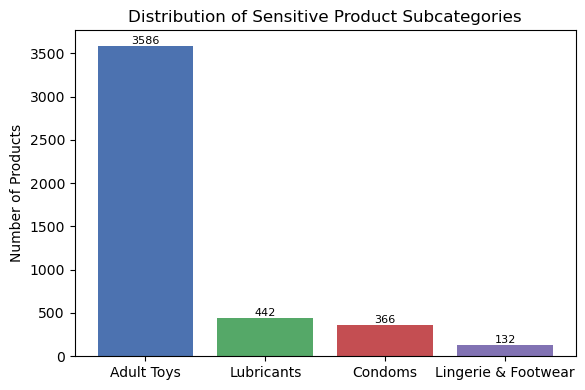

In [26]:
subcategories = ["Adult Toys", "Lubricants", "Condoms", "Lingerie & Footwear"]
counts = [3586, 442, 366, 132]

colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B3"]  

plt.figure(figsize=(6, 4))
bars = plt.bar(subcategories, counts, color=colors)  
plt.ylabel("Number of Products")
plt.title("Distribution of Sensitive Product Subcategories")


for bar, cnt in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(cnt),
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig("sensitive_subcategory_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

In [31]:
pct_discounted = (df_sw["discount_pct"] > 0).mean() * 100
pct_best_seller = df_sw["isBestSeller"].astype(bool).mean() * 100

print(f"Discounted products: {pct_discounted:.1f}%")
print(f"Best-Seller products: {pct_best_seller:.1f}%")

Discounted products: 29.9%
Best-Seller products: 0.9%


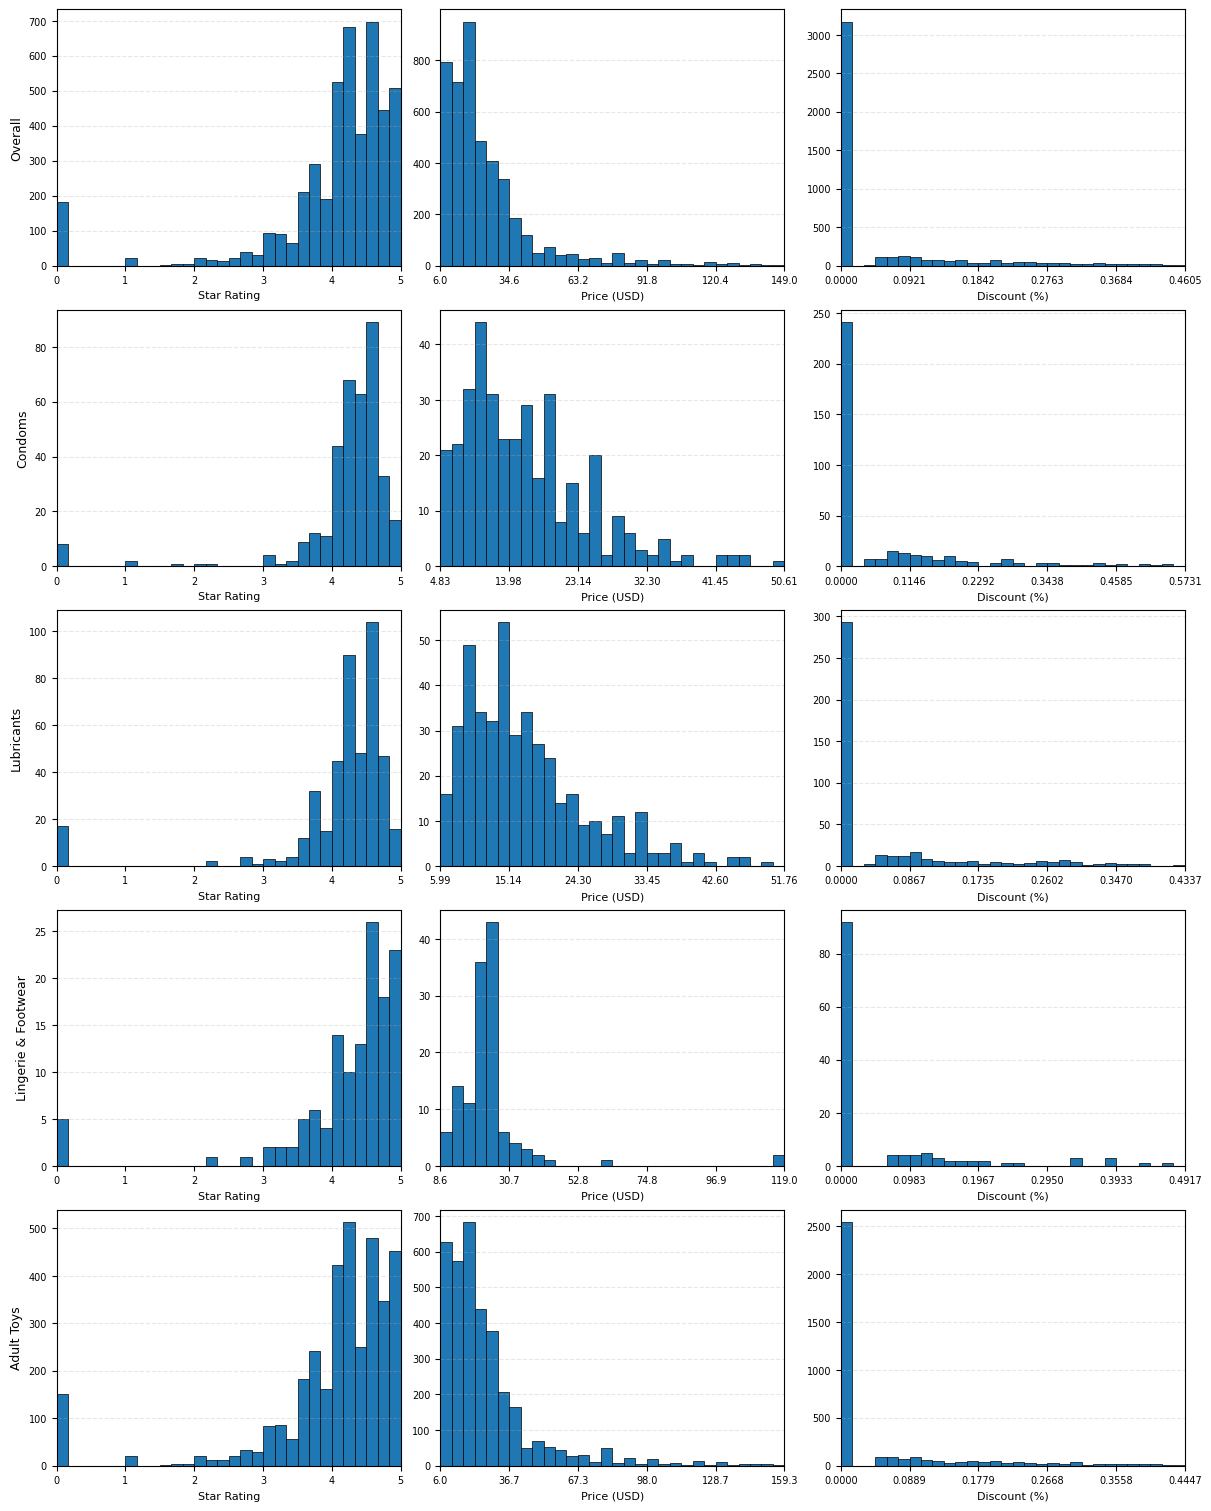

In [32]:
# distribution figures v2
label_map = {1: "Condoms", 2: "Lubricants",
             3: "Lingerie & Footwear", 4: "Adult Toys"}
df_sw["subcat_name"] = df_sw["subcategory"].map(label_map)

categories = ["Overall"] + list(label_map.values())

features = [
    ("stars",  "Star Rating"),
    ("price",  "Price (USD)"),
    ("discount_pct", "Discount (%)")
]

n_rows, n_cols = len(categories), len(features)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 4, n_rows * 3),
    constrained_layout=True
)

for i, cat in enumerate(categories):
    subset = df_sw if cat == "Overall" else df_sw[df_sw["subcat_name"] == cat]

    for j, (col, xlab) in enumerate(features):
        ax = axes[i, j]
        data = subset[col].dropna()

        if data.empty:
            ax.set_visible(False)
            continue

        q1, q99 = np.percentile(data, [1, 99])
        min_v = q1 if q1 > 0 else data.min()
        max_v = q99
        bins   = np.linspace(min_v, max_v, 31)
        xticks = np.linspace(min_v, max_v, 6)

        ax.hist(data, bins=bins, edgecolor="black", linewidth=0.5)
        ax.set_xlabel(xlab, fontsize=8)
        if j == 0:
            ax.set_ylabel(cat, fontsize=9)
        else:
            ax.set_ylabel("")

        ax.set_xticks(xticks)
        ax.set_xlim(min_v, max_v)
        ax.tick_params(axis="both", labelsize=7)
        ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.show()

## Insensitive product group  

In [5]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

CTRL_PATTERNS = {
             "Condoms_Ctrl": (
                 r"\b("
                 r"bandages?|plaster|first[- ]aid|gauze|adhesive strip|medical tape|wound care"
                 r")\b"
             ),
             "Lubricants_Ctrl": (
                 r"\b("
                 r"hand (soap|wash)|liquid soap|body (wash|lotion|cream)|"
                 r"moisturizing lotion|shower gel"
                 r")\b"
             ),
             "Lingerie_Ctrl": (
                 r"\b("
                 r"underwear|briefs|boxers|panties|sports bra|bralette|"
                 r"socks?|stockings?|sneakers?|running shoes?"
                 r")\b"
             ),
             "AdultToys_Ctrl": (
                 r"\b("
                 r"(handheld )?massager|massage( gun| stick| roller| pillow| pad)|"
                 r"shiatsu|percussion gun|theragun|vibration therapy|"
                 r"muscle (roller|relaxer)|tens (unit|machine)|"
                 r"heating (pad|wrap|belt)|heat therapy|neck\s*warmer|"
                 r"microwaveable (pillow|bag)|hot cold pack|"
                 r"pet (leash|harness|collar)|dog (leash|harness)|cat leash|"
                 r"foam roller|yoga (strap|wheel|block)|resistance (band|loop)|"
                 r"stretch strap|therapy (ball|roller)|peanut ball|lacrosse ball|"
                 r"gua sha|scraping tool|cupping (set|therapy)|"
                 r"balance board|wobble board|massage chair|foot massager|foot spa"
                 r")\b"
), }


CTRL_COMPILED = {k: re.compile(v, re.I) for k, v in CTRL_PATTERNS.items()}

def classify_control(title, cat):
    txt = f"{title or ''} {cat or ''}".lower()
    for cls, pat in CTRL_COMPILED.items():
        if pat.search(txt):
            return cls
    return None

CODE_MAP_CTRL = {"Condoms_Ctrl":1, "Lubricants_Ctrl":2,
                 "Lingerie_Ctrl":3, "AdultToys_Ctrl":4}

df_all = df_product.copy()
df_all["ctrl_class"] = df_all.apply(
    lambda r: classify_control(r.get("title", ""),
                               r.get("category_name", "")),   # ← FIX 如列名不同
    axis=1
)
df_all = df_all.dropna(subset=["ctrl_class"])
df_all["subcategory"] = df_all["ctrl_class"].map(CODE_MAP_CTRL).astype(int)

def bin_cols(df, price_edges):
    df = df.copy()
    df["price_log"] = np.log1p(df["price"].clip(lower=0))
    price_cat = pd.cut(df["price_log"], price_edges,
                       include_lowest=True)
    df["price_bin"] = price_cat.cat.codes.astype("Int8")      
    star_cat = pd.cut(df["stars"], [0,2,3,3.5,4,4.5,5],
                      include_lowest=True)
    df["star_bin"]  = star_cat.cat.codes.astype("Int8")
    df["disc_bin"]  = (df["discount_pct"] > 0.001).astype("Int8")  
    return df

log_price_all = np.log1p(
    pd.concat([df_sw["price"], df_all["price"]]).clip(lower=0)
)
price_edges = np.unique(
    log_price_all.quantile([0, .2, .4, .6, .8, 1]).values
)
if len(price_edges) < 3:  
    price_edges = np.linspace(log_price_all.min(), log_price_all.max(), 4)

df_sw  = bin_cols(df_sw,  price_edges)
df_all = bin_cols(df_all, price_edges)

key_cols = ["subcategory", "price_bin", "star_bin", "disc_bin"]
df_sw ["layer_key"] = df_sw [key_cols].astype(str).agg("-".join, axis=1)
df_all["layer_key"] = df_all[key_cols].astype(str).agg("-".join, axis=1)

N_TARGET   = 4500
layer_dist = df_sw["layer_key"].value_counts(normalize=True)
target_counts = (layer_dist * N_TARGET).round().astype(int)
target_counts.iloc[0] += N_TARGET - target_counts.sum()   # 修正和 = 4500


ctrl_samples, shortfall = [], {}
for key, n_need in target_counts.items():
    pool = df_all[df_all["layer_key"] == key]
    n_pool = len(pool)
    if n_pool == 0:
        shortfall[key] = n_need
        continue
    replace_flag = n_pool < n_need
    if replace_flag:
        shortfall[key] = n_need - n_pool
    ctrl_samples.append(
        pool.sample(n=n_need, replace=replace_flag, random_state=RANDOM_STATE)
    )

if not ctrl_samples:
    raise RuntimeError("Error")

df_ctrl = pd.concat(ctrl_samples, ignore_index=True)

print(f"\n Sampled Control Size = {len(df_ctrl)}")
print("Shortfall layers:", len(shortfall))


def smd(a, b):
    return (a.mean() - b.mean()) / np.sqrt(0.5*(a.var()+b.var()) + 1e-9)

for col in ["price_log", "stars", "discount_pct"]:
    print(f"SMD {col}: {smd(df_sw[col], df_ctrl[col]):.3f}")


✔ Sampled Control Size = 4486
⚠ Shortfall layers: 43
SMD price_log: 0.018
SMD stars: 0.005
SMD discount_pct: -0.113


In [6]:
subcat_mapping = {
    1: "Condoms",
    2: "Lubricants", 
    3: "Lingerie & Footwear",
    4: "Adult Toys"
}

df_sw['subcat_name'] = df_sw['subcategory'].map(subcat_mapping)
df_ctrl = df_ctrl.rename(columns={'ctrl_class': 'subcat_name'})
df_sw["T"]   = 1          # Sensitive
df_ctrl["T"] = 0          # Control
df = pd.concat([df_sw, df_ctrl], ignore_index=True)

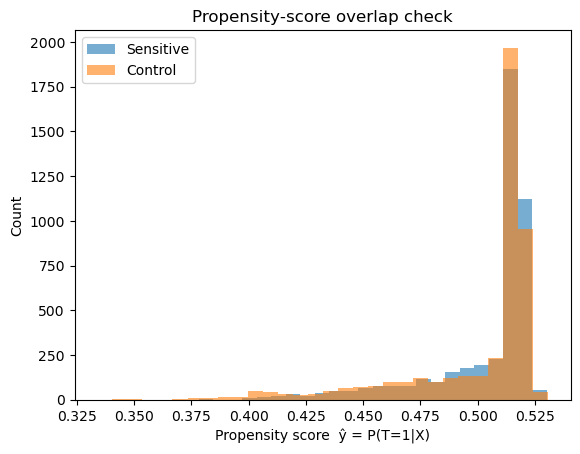

In [11]:
X_cols = [
    "price_log",
    "stars",
    "discount_pct",
    "subcategory",       
]

X = df[X_cols].values
T = df["T"].values

from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter=1000)
e_hat = logit.fit(X, T).predict_proba(X)[:, 1]   # P(T=1 | X)

import matplotlib.pyplot as plt

plt.hist(e_hat[T==1], bins=30, alpha=0.6, label="Sensitive")
plt.hist(e_hat[T==0], bins=30, alpha=0.6, label="Control")
plt.xlabel("Propensity score  ŷ = P(T=1|X)")
plt.ylabel("Count")
plt.legend()
plt.title("Propensity‐score overlap check")
#plt.savefig('propensity_score_overlap.png')
plt.show()

In [15]:
for col in ["price_log","stars","discount_pct"]:
    vr = df_sw[col].var() / df_ctrl[col].var()
    print(f"VR({col}): {vr:.2f}")

from scipy.stats import ks_2samp
ks, p = ks_2samp(df_sw["price_log"], df_ctrl["price_log"])
print("KS(price_log):", ks)

w = T/e_hat + (1-T)/(1-e_hat)
ess = (w.sum()**2)/( (w**2).sum() )
print("ESS =", int(ess), " / ", len(w))

VR(price_log): 0.93
VR(stars): 0.96
VR(discount_pct): 0.66
KS(price_log): 0.024777926475829257
ESS = 8984  /  9012


In [9]:
df_ctrl['subcategory'].value_counts()

subcategory
4    3553
2     435
1     366
3     132
Name: count, dtype: int64

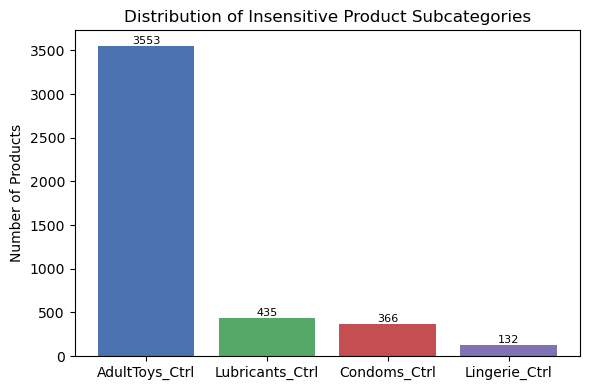

In [10]:
subcategories = ["AdultToys_Ctrl", "Lubricants_Ctrl", "Condoms_Ctrl", "Lingerie_Ctrl"]
counts = [3553, 435, 366, 132]

colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B3"]  

plt.figure(figsize=(6, 4))
bars = plt.bar(subcategories, counts, color=colors)  
plt.ylabel("Number of Products")
plt.title("Distribution of Insensitive Product Subcategories")


for bar, cnt in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(cnt),
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig("insensitive_subcategory_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

In [39]:
pct_discounted = (df_ctrl["discount_pct"] > 0).mean() * 100
pct_best_seller = df_ctrl["isBestSeller"].astype(bool).mean() * 100

print(f"Discounted products: {pct_discounted:.1f}%")
print(f"Best-Seller products: {pct_best_seller:.1f}%")

Discounted products: 29.8%
Best-Seller products: 0.7%


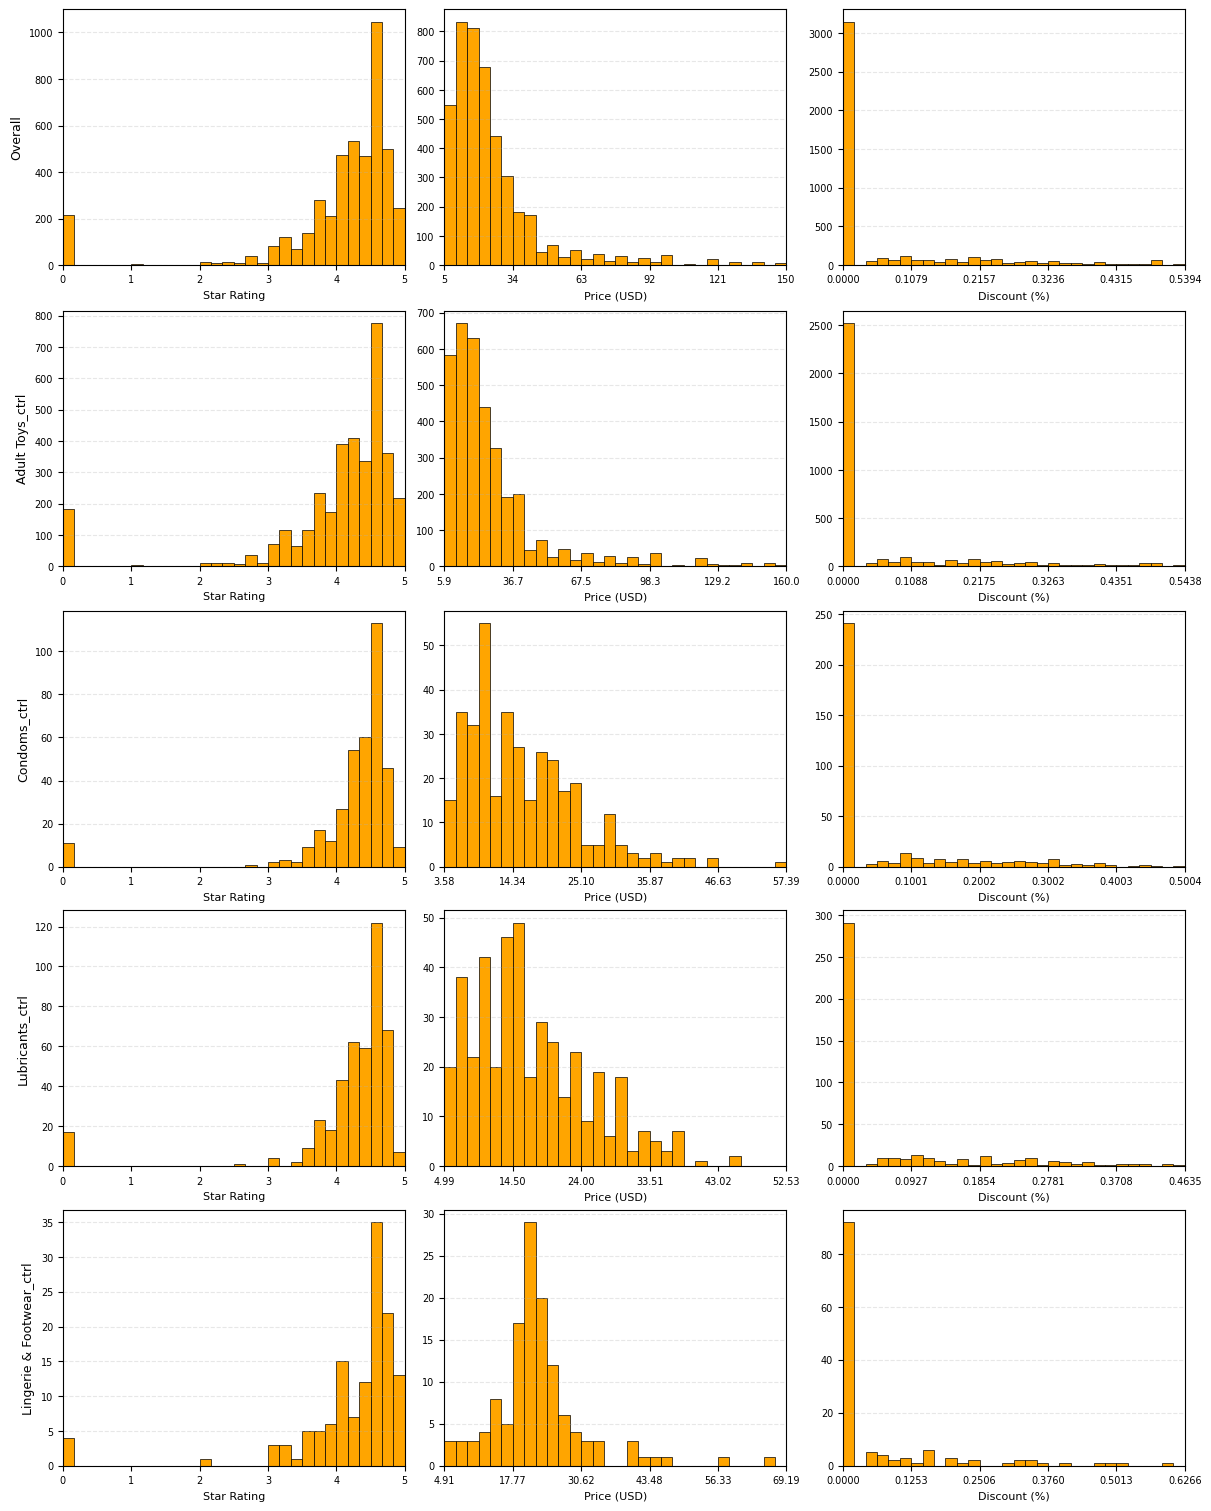

In [21]:
categories = ["Overall"] + list(df_ctrl["ctrl_class"].unique())

features = [
    ("stars",        "Star Rating"),
    ("price",        "Price (USD)"),
    ("discount_pct", "Discount (%)"),
]

n_rows, n_cols = len(categories), len(features)
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 4, n_rows * 3),
    constrained_layout=True
)

for i, cat in enumerate(categories):
    subset = (
        df_ctrl if cat == "Overall"
        else df_ctrl[df_ctrl["ctrl_class"] == cat]
    )

    for j, (col, xlab) in enumerate(features):
        ax   = axes[i, j]
        data = subset[col].dropna()

        if data.empty:
            ax.set_visible(False)
            continue

        q1, q99 = np.percentile(data, [1, 99])
        min_v   = q1 if q1 > 0 else data.min()
        max_v   = q99
        bins    = np.linspace(min_v, max_v, 31)
        xticks  = np.linspace(min_v, max_v, 6)

        ax.hist(data, bins=bins, edgecolor="black", color="orange", linewidth=0.5)
        ax.set_xlabel(xlab, fontsize=8)
        if j == 0:
            ax.set_ylabel(cat, fontsize=9)
        else:
            ax.set_ylabel("")

        ax.set_xticks(xticks)
        ax.set_xlim(min_v, max_v)
        ax.tick_params(axis="both", labelsize=7)
        ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.show()

# Feature  Engineering

## Text arousal level score 

In [5]:
import textwrap, argparse, os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm

In [8]:
def parse_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser(
        description="Score product titles with arousal level (0‑10) using VAD‑BERT"
    )
    parser.add_argument("--input", required=True, help="Input CSV with a `title` column")
    parser.add_argument("--output", default=None, help="Output CSV path")
    parser.add_argument("--batch_size", type=int, default=32, help="Batch size")
    parser.add_argument(
        "--device",
        default="auto",
        help="'cuda', 'cpu', or a CUDA index like cuda:0. 'auto' picks cuda if available",
    )
    return parser.parse_args()

model_name = "RobroKools/vad-bert"     
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

tok = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device).eval()

batch_size = 32
arousal_scores = []

with torch.no_grad():
    for i in tqdm(range(0, len(df), batch_size), desc="Scoring titles"):
        batch = df["title"].iloc[i:i+batch_size].tolist()
        enc = tok(batch, padding=True, truncation=True, return_tensors="pt").to(device)
        logits = model(**enc).logits                # [B, 3] -> valence, arousal, dominance
        arousal_scores.extend(logits[:, 1].sigmoid().cpu().numpy())  # 0–1

In [2]:
import scipy.stats as st

In [10]:
arousal_scores = np.array(arousal_scores)
df["title_arousal"]        = arousal_scores                    
df["title_arousal_0_10"]   = (arousal_scores * 10).round(2) 

ranks = st.rankdata(arousal_scores, method="average")
df["title_arousal_q_0_10"] = (ranks / len(df) * 10).round(2)
df["title_arousal_mm_0_10"] = (
    (arousal_scores - arousal_scores.min())
    / (arousal_scores.max() - arousal_scores.min()) * 10
).round(2)

In [23]:
def group_label(x):
    if x in [1,2,3,4]:
        return "Sensitive"
    elif x in [5,6,7,8]:
        return "Insensitive"
    else:
        return "Other"

df['group'] = df['subcat_all'].apply(group_label)

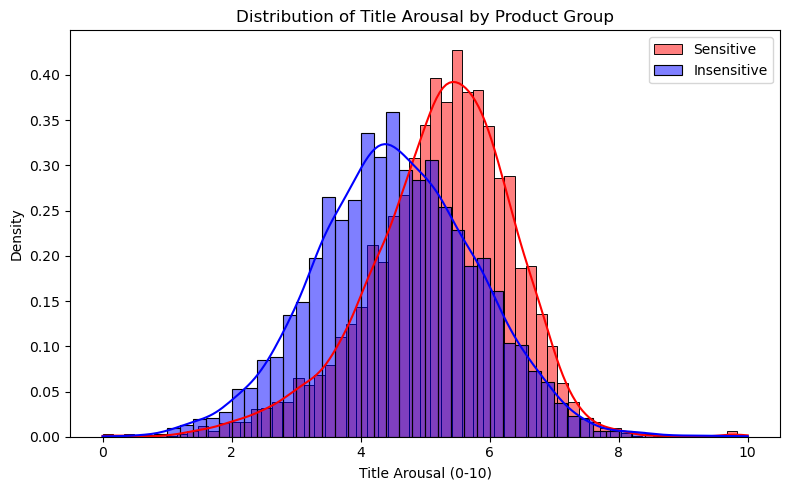

In [27]:
plt.figure(figsize=(8,5))
sns.histplot(df[df['group']=='Sensitive']['title_arousal_mm_0_10'], color='red', label='Sensitive', kde=True, stat="density", alpha=0.5)
sns.histplot(df[df['group']=='Insensitive']['title_arousal_mm_0_10'], color='blue', label='Insensitive', kde=True, stat="density", alpha=0.5)
plt.title("Distribution of Title Arousal by Product Group")
plt.xlabel("Title Arousal (0-10)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig("title_arousal_distribution.png", dpi=300)
plt.show()

## Image arousal level score

In [7]:
import requests, io, time
from PIL import Image
import open_clip
from tqdm.auto import tqdm

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="openai"
)
tokenizer = open_clip.get_tokenizer("ViT-B-32")
model = model.to(device).eval()

prompts = ["an erotic exciting product photo",
           "a neutral non-arousing product photo"]
with torch.no_grad():
    text_tokens = tokenizer(prompts).to(device)
    text_embs  = model.encode_text(text_tokens).float()      
    text_embs /= text_embs.norm(dim=-1, keepdim=True)        

exciting_vec, neutral_vec = text_embs                    

UA = {"User-Agent": "Mozilla/5.0"}
def fetch_img_tensor(url, retry=2, timeout=8):
    for _ in range(retry + 1):
        try:
            r = requests.get(url, headers=UA, timeout=timeout)
            if r.ok and "image" in r.headers.get("Content-Type", ""):
                img = Image.open(io.BytesIO(r.content)).convert("RGB")
                return preprocess(img).unsqueeze(0)          
        except Exception:
            time.sleep(0.3)
    return None

image_scores, fails = [], 0

for url in tqdm(df["imgUrl"], desc="Scoring images"):
    img_tensor = fetch_img_tensor(url)
    if img_tensor is None:
        image_scores.append(np.nan); fails += 1; continue

    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        img_emb = model.encode_image(img_tensor).float()    
        img_emb /= img_emb.norm(dim=-1, keepdim=True)
        diff = torch.matmul(img_emb, exciting_vec) - torch.matmul(img_emb, neutral_vec)
        prob = torch.sigmoid(diff).item()                   
        image_scores.append(prob)

Device: cpu


/Users/apple/anaconda3/lib/python3.11/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


Scoring images:   0%|          | 0/9012 [00:00<?, ?it/s]

Done!  Un-downloadable images: 3552
count    5460.000000
mean        5.018485
std         0.029196
min         4.920000
25%         5.000000
50%         5.020000
75%         5.040000
max         5.100000
Name: image_arousal_0_10, dtype: float64


In [16]:
df["image_arousal"] = image_scores                   # 0-1
df["image_arousal_0_10"] = (df["image_arousal"]*10).round(2)

df["image_arousal_q_0_10"] = (ranks / len(df) * 10).round(2)
df["image_arousal_mm_0_10"] = (
    (image_scores - image_scores.min())
    / (image_scores.max() - image_scores.min()) * 10
).round(2)

Done!  Un-downloadable images: 3552


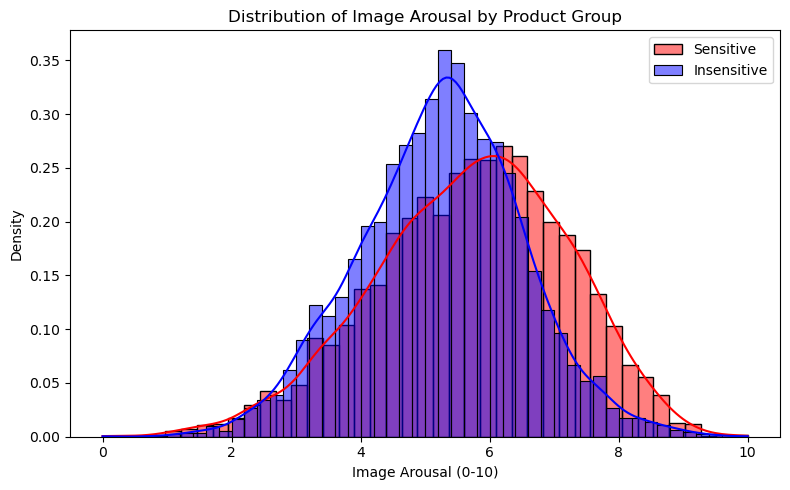

In [29]:
plt.figure(figsize=(8,5))

sns.histplot(df[df['group']=='Sensitive']['image_arousal_mm_0_10'],
             color='red', label='Sensitive', kde=True, stat="density", alpha=0.5)
sns.histplot(df[df['group']=='Insensitive']['image_arousal_mm_0_10'],
             color='blue', label='Insensitive', kde=True, stat="density", alpha=0.5)

plt.title("Distribution of Image Arousal by Product Group")
plt.xlabel("Image Arousal (0-10)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig("image_arousal_distribution.png", dpi=300)
plt.show()

In [19]:
df.to_excel('df.xlsx', index=False)

## DAG

In [32]:
from graphviz import Digraph

dot = Digraph('Focus_DAG', format='pdf')
dot.attr(rankdir='LR', splines='polyline', nodesep='0.6', ranksep='0.4')
dot.attr('node', shape='box', style='rounded,filled', fillcolor='white',
         fontname='Times-Roman', fontsize='10')

for code, label in {
    'C_price':  'Price',
    'C_disc' :  'Discount_Pct',
    'C_stars':  'Stars',
    'C_sub'  :  'Subcategory'
}.items():
    dot.node(code, label)

dot.attr('node', penwidth='1.8')
dot.node('T_title', 'Title_Arousal')
dot.node('T_image', 'Image_Arousal')

dot.attr('node', penwidth='2', fillcolor='#EEEEEE')
dot.node('Y_sales', 'log(Sales)')

for c in ['C_price','C_disc','C_stars','C_sub']:
    dot.edge(c, 'T_title')
    dot.edge(c, 'T_image')
    dot.edge(c, 'Y_sales')

dot.edge('T_title', 'Y_sales')
dot.edge('T_image', 'Y_sales')

dot.render('simplified_dag', view=True)  

'simplified_dag.pdf'

## Causal Forest DML 

In [3]:
df = pd.read_excel("df.xlsx")

In [4]:
df["title_len"] = df["title"].fillna("").str.split().str.len()
df["isBestSeller"] = df["isBestSeller"].fillna(0).astype(int)
df["stars"] = df["stars"].fillna(df["stars"].median())
df["reviews_count"] = df["reviews"].fillna(0)
df["discount_pct"] = (
1 - df["price"] / df["listPrice"].replace(0, np.nan)
).clip(0, 1).fillna(0)

In [17]:
import numpy as np, pandas as pd, warnings
from econml.dml import CausalForestDML
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
warnings.filterwarnings("ignore")

y = np.log1p(df["boughtInLastMonth"].fillna(0)).values          

T = df[["title_arousal_mm_0_10", "image_arousal_mm_0_10"]].values  

num_cols = ["price","discount_pct","stars"] 
cat_cols = ["subcategory"]

ct = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])
X = ct.fit_transform(df)                                           

est = CausalForestDML(
        model_t = RandomForestRegressor(300, max_depth=6, random_state=0),
        model_y = RandomForestRegressor(300, max_depth=6, random_state=0),
        n_estimators    = 500,
        min_samples_leaf= 10,
        max_depth       = 6,
        random_state    = 0
).fit(y, T, X=X)

def wald_ci(point, se, alpha=0.05):
    z = norm.ppf(1-alpha/2)
    return point - z*se, point + z*se

ate_vec  = est.const_marginal_ate(X=X)                           
se_vec   = est.const_marginal_ate_inference(X=X).stderr_mean       

labels = ["Title arousal  +1", "Image arousal  +1"]
for lab, est_i, se_i in zip(labels, ate_vec, se_vec):
    z     = est_i / se_i
    p     = 2 * (1 - norm.cdf(abs(z)))
    ci_lo = est_i - 1.96 * se_i
    ci_hi = est_i + 1.96 * se_i
    pct   = (np.exp(est_i) - 1) * 100          

    print(f"{lab:<18s}  Δlog = {est_i:+.4f}  SE = {se_i:.4f}  "
          f"95% CI [{ci_lo:+.4f}, {ci_hi:+.4f}]   p = {p:.3f}   "
          f"≈ {pct:+.2f}% sales")

Title arousal  +1   Δlog = +0.1272  SE = 0.0656  95% CI [-0.0015, +0.2558]   p = 0.053   ≈ +13.56% sales
Image arousal  +1   Δlog = +0.0586  SE = 0.0666  95% CI [-0.0720, +0.1892]   p = 0.379   ≈ +6.03% sales


In [6]:
def grab(obj, names):
    for n in names:
        if hasattr(obj, n):
            v = getattr(obj, n)
            v = v() if callable(v) else v
            try:    return float(v)
            except: pass
    return np.nan

joint_inf = est.ate_inference(X=X)       

joint_ate = grab(joint_inf, ["mean_point", "effect", "point_estimate", "__float__"])
joint_se  = grab(joint_inf, ["stderr_mean", "stderr"])

z_joint  = joint_ate / joint_se
p_joint  = 2 * (1 - norm.cdf(abs(z_joint)))
ci_lo, ci_hi = joint_ate - 1.96*joint_se, joint_ate + 1.96*joint_se
pct_joint = (np.exp(joint_ate) - 1) * 100

print(f"Joint ATE  (Title +1 & Image +1)")
print(f"  Δlog = {joint_ate:+.4f}  SE = {joint_se:.4f}  "
      f"95% CI [{ci_lo:+.4f}, {ci_hi:+.4f}]  p = {p_joint:.3f}  "
      f"≈ {pct_joint:+.2f}% sales")

Joint ATE  (Title +1 & Image +1)
  Δlog = +0.1858  SE = 0.0870  95% CI [+0.0152, +0.3563]  p = 0.033  ≈ +20.41% sales


In [7]:
mask_sens = df["group"] == "Sensitive"
mask_ins  = ~mask_sens                        

ate_s, se_s = (
    est.const_marginal_ate(X=X[mask_sens]),
    est.const_marginal_ate_inference(X=X[mask_sens]).stderr_mean,
)
ate_i, se_i = (
    est.const_marginal_ate(X=X[mask_ins]),
    est.const_marginal_ate_inference(X=X[mask_ins]).stderr_mean,
)

diff    = ate_s - ate_i
se_diff = np.sqrt(se_s**2 + se_i**2)
p_diff  = 2 * (1 - norm.cdf(np.abs(diff / se_diff)))

labels  = ["Title arousal  +1", "Image arousal +1"]
to_pct  = lambda d: (np.exp(d) - 1) * 100
ci95    = lambda m, s: (m - 1.96 * s, m + 1.96 * s)

for i, lab in enumerate(labels):
    z_s, p_s = ate_s[i] / se_s[i], 2*(1-norm.cdf(abs(ate_s[i]/se_s[i])))
    z_i, p_i = ate_i[i] / se_i[i], 2*(1-norm.cdf(abs(ate_i[i]/se_i[i])))

    print(f"\n=== {lab} ===")

    print(f"Sensitive    Δlog = {ate_s[i]:+.4f} ± {se_s[i]:.4f} "
          f"95%CI [{ci95(ate_s[i], se_s[i])[0]:+.4f}, {ci95(ate_s[i], se_s[i])[1]:+.4f}] "
          f"p = {p_s:.3f}   ({to_pct(ate_s[i]):+.2f} % sales)")

    print(f"Insensitive  Δlog = {ate_i[i]:+.4f} ± {se_i[i]:.4f} "
          f"95%CI [{ci95(ate_i[i], se_i[i])[0]:+.4f}, {ci95(ate_i[i], se_i[i])[1]:+.4f}] "
          f"p = {p_i:.3f}   ({to_pct(ate_i[i]):+.2f} % sales)")

    print(f"Difference   Δ    = {diff[i]:+.4f} ± {se_diff[i]:.4f} "
          f"95%CI [{ci95(diff[i], se_diff[i])[0]:+.4f}, {ci95(diff[i], se_diff[i])[1]:+.4f}] "
          f"p = {p_diff[i]:.3f}")


=== Title arousal  +1 ===
Sensitive    Δlog = +0.1357 ± 0.0660 95%CI [+0.0063, +0.2651] p = 0.040   (+14.53 % sales)
Insensitive  Δlog = +0.1186 ± 0.0653 95%CI [-0.0094, +0.2465] p = 0.069   (+12.59 % sales)
Difference   Δ    = +0.0171 ± 0.0928 95%CI [-0.1648, +0.1991] p = 0.854

=== Image arousal +1 ===
Sensitive    Δlog = +0.0228 ± 0.0619 95%CI [-0.0985, +0.1441] p = 0.713   (+2.30 % sales)
Insensitive  Δlog = +0.0948 ± 0.0711 95%CI [-0.0446, +0.2341] p = 0.183   (+9.94 % sales)
Difference   Δ    = -0.0720 ± 0.0943 95%CI [-0.2567, +0.1128] p = 0.445


In [8]:
from scipy.stats import norm
import numpy as np

mask_s = df["group"] == "Sensitive"
mask_i = ~mask_s                     # Insensitive

def grab(obj, names):
    for n in names:
        if hasattr(obj, n):
            v = getattr(obj, n);  v = v() if callable(v) else v
            try: return float(v)
            except: pass
    return np.nan

def joint_est(mask):
    inf = est.ate_inference(X=X[mask])
    m   = grab(inf, ["mean_point", "effect", "point_estimate", "__float__"])
    se  = grab(inf, ["stderr_mean", "stderr"])
    return m, se

m_s, se_s = joint_est(mask_s)
m_i, se_i = joint_est(mask_i)

def wald(m, se):
    z = m / se;  p = 2*(1-norm.cdf(abs(z)))
    ci = (m - 1.96*se, m + 1.96*se)
    return p, ci

p_s, ci_s = wald(m_s, se_s)
p_i, ci_i = wald(m_i, se_i)

diff    = m_s - m_i
se_diff = np.sqrt(se_s**2 + se_i**2)
p_diff, ci_diff = wald(diff, se_diff)

to_pct = lambda d: (np.exp(d) - 1) * 100

print("\n=== Joint ATE  (Title +1  &  Image +1) ===")
print(f"Sensitive    Δlog = {m_s:+.4f} ± {se_s:.4f}  "
      f"95%CI [{ci_s[0]:+.4f}, {ci_s[1]:+.4f}]  p = {p_s:.3f}  "
      f"≈ {to_pct(m_s):+.2f}% sales")

print(f"Insensitive  Δlog = {m_i:+.4f} ± {se_i:.4f}  "
      f"95%CI [{ci_i[0]:+.4f}, {ci_i[1]:+.4f}]  p = {p_i:.3f}  "
      f"≈ {to_pct(m_i):+.2f}% sales")

print(f"Difference   Δ    = {diff:+.4f} ± {se_diff:.4f}  "
      f"95%CI [{ci_diff[0]:+.4f}, {ci_diff[1]:+.4f}]  p = {p_diff:.3f}")


=== Joint ATE  (Title +1  &  Image +1) ===
Sensitive    Δlog = +0.1585 ± 0.0837  95%CI [-0.0055, +0.3225]  p = 0.058  ≈ +17.17% sales
Insensitive  Δlog = +0.2133 ± 0.0903  95%CI [+0.0364, +0.3902]  p = 0.018  ≈ +23.78% sales
Difference   Δ    = -0.0548 ± 0.1231  95%CI [-0.2960, +0.1864]  p = 0.656


In [20]:
def fit_cf(y_sub, T_sub, X_sub, seed=0):
    return CausalForestDML(
        model_t = RandomForestRegressor(300, max_depth=6, random_state=seed),
        model_y = RandomForestRegressor(300, max_depth=6, random_state=seed),
        n_estimators    = 500,
        min_samples_leaf= 10,
        max_depth       = 6,
        random_state    = seed
    ).fit(y_sub, T_sub, X=X_sub)

for seed in [1, 2, 3]:
    rng   = np.random.RandomState(seed)
    mask  = rng.rand(len(df)) < 0.5            
    est_h = fit_cf(y[mask], T[mask], X[mask], seed=seed)
    ate_h = est_h.const_marginal_ate(X=X[mask])[0]   
    print(f"Seed {seed}: half-sample ATE(title) = {ate_h:.4f}")

Seed 1: half-sample ATE(title) = 0.1555
Seed 2: half-sample ATE(title) = 0.0920
Seed 3: half-sample ATE(title) = 0.1262


In [24]:
n_perm = 50
rng = np.random.RandomState(0)
ate_perm = []

for i in range(n_perm):
    T_shuf = rng.permutation(T)
    est_p  = create_cf(seed=i).fit(y, T_shuf, X=X)
    ate_perm.append(est_p.const_marginal_ate(X=X)[0])

p_perm = (np.abs(ate_perm) >= abs(ate_true)).mean()
print(f"Permutation p (50 reps) ≈ {p_perm:.3f}")

Permutation p (50 reps) ≈ 0.000
